In [1]:
import torch
import torch.optim as optim
import os
import sys
import random
import matplotlib.pyplot as plt
# hack to perform relative imports
sys.path.append('../')
from ChrisCode import train_agent, SQN
import time


We define the seeds, hyperparameters and initial weights to values that reached the Open AI gym standard succesfully. This should make the results reproducible if you install the virtual environment specified in requirements.txt



In [2]:
torch.backends.cudnn.deterministic = True
import numpy as np
np.random.seed(1)

In [3]:
torch.backends.cudnn.benchmark

False

Next, we define the environment and all the hyperparameters for a non-spiking Q-network. We then set up the result directory. 

In [4]:
#CartPole
env = 'CartPole-v0'

#hyperparameters
BATCH_SIZE = 128
DISCOUNT_FACTOR = 0.999
EPSILON_START = 1.0
EPSILON_END = 0.05
EPSILON_DECAY = 0.999
TARGET_UPDATE_FREQUENCY = 10
LEARNING_RATE = 0.001
REPLAY_MEMORY_SIZE = 4*10**4
# minimum size of the replay memory before the training starts
INITIAL_REPLAY_SIZE = 0
# the gym standard for CartPole ("solving" it) is to achieve a 100-episode average of <=195 for 100 consecutive episodes
GYM_TARGET_AVG = 195
GYM_TARGET_DURATION = 100
# maximum number of steps before the environment is reset
MAX_STEPS = 200
# number of episodes to train the agent
NUM_EPISODES = 20 #TODO: change
# whether to use Double Q Learning and Gradient Clipping
DOUBLE_Q = True
GRADIENT_CLIPPING = True
# whether to render the environment
RENDER = False

# device: automatically runs on GPU, if a GPU is detected, else uses CPU
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda")

### Training of a spiking DQN or DSQN
Next, we train a DSQN using the same hyperparameters as far as possible. That is, all hyperparameters are the same, but we need to define some additional hyperparameters. We adapted the surrogate gradient algorithm we use for the direct training from the SpyTorch jupyter notebooks (available from https://github.com/fzenke/spytorch as of 06.12.2019).

In [5]:
# First we set up a new sub directory

# We use a non-leaky integrate-and-fire neuron
ALPHA = 0
BETA = 1
# Simulation time is chosen relatively short, such that the network does not need too much time to run, but not too short,
# such that it can still learn something
SIMULATION_TIME = 20
# We also have to define the input/output and reset methods, to our knowledge, SpyTorch supports only potential outputs 
# and reset-by-subtraction. As input method we use constant input currents. It would be interesting to see if SpyTorch
# can also use reset-to-zero, as this would make it more similar to the iaf_delta models in NEST and SpyNNaker
ENCODING = 'constant'
DECODING = 'potential'
RESET = 'subtraction'
# SpyTorch uses a fixed threshold of one, we didn't test other thresholds, but should be possible
THRESHOLD = 1

We again set the seeds in a way such that the gym standard is reached. We obtained those seed from our experiments, where we saved the seeds upon succesfully reaching the gym standard.

In [6]:
# alternatively use the seeds gym: 240, torch: 18, random: 626 and a learning rate of 0.0005 
# to get the same results as figure 4.9 in the thesis
torch.manual_seed(467)
random.seed(208)
gym_seed = 216


Now, we set up the neural network. Note, that SpyTorch does not support biases, so we instead add a constant input to each observation (equivalent to first layer biases) and add one additional neuron to each hidden layer to compensate for the missing biases.

In [7]:
architecture = [4,17,17,2]
policy_net = SQN.SQN(architecture,device,alpha=ALPHA,beta=BETA,simulation_time=SIMULATION_TIME,add_bias_as_observation=True,
                  encoding=ENCODING,decoding=DECODING,reset=RESET,threshold=THRESHOLD)
# load the fixed initial weights, remove this line to get random initial weights
#policy_net.load_state_dict(torch.load('./../../CartPole-v0/DSQN-Surrogate-Gradients/initial/model.pt'))

target_net = SQN.SQN(architecture,device,alpha=0,beta=1,simulation_time=SIMULATION_TIME,add_bias_as_observation=True,
                  encoding=ENCODING,decoding=DECODING,reset=RESET,threshold=THRESHOLD)
target_net.load_state_dict(policy_net.state_dict())

# initialize optimizer
#optimizer = optim.Adam(policy_net.parameters(), lr=LEARNING_RATE)



The plot again shows the rewards in each episode (blue) and the average reward over the last 100 episodes (orange).

The next experiment in this series is Load-DQN.

In [8]:
for l in policy_net.parameters():#.state_dict()[0]:
    print(l.shape)

torch.Size([5, 17])
torch.Size([17, 17])
torch.Size([17, 2])


In [9]:
from Code import SNN

In [10]:
architecture = [4,17,17,2]

neuron_params = {
    'threshold': 1,
    'alpha': ALPHA,
    'beta': BETA,
    'reset_zero': False
}

my_net = SNN.FeedForwardSNN(architecture, SNN.LIFNeuron, neuron_params, SNN.SuperSpike.apply, SNN.PotentialNeuron)
my_target_net = SNN.FeedForwardSNN(architecture, SNN.LIFNeuron, neuron_params, SNN.SuperSpike.apply, SNN.PotentialNeuron)

In [11]:
'''
mp = list(my_net.parameters())
hp = list(policy_net.parameters())
mp[0].data = hp[0].data.T.detach().clone()
mp[1].data = hp[1].data.T.detach().clone()
mp[2].data = hp[2].data.T.detach().clone()
mp = list(my_target_net.parameters())
mp[0].data = hp[0].data.T.detach().clone()
mp[1].data = hp[1].data.T.detach().clone()
mp[2].data = hp[2].data.T.detach().clone()
'''

mp = list(my_net.parameters())
hp = list(policy_net.parameters())
mp[0].data = hp[0].data.detach().clone()
mp[1].data = hp[1].data.detach().clone()
mp[2].data = hp[2].data.detach().clone()
mp = list(my_target_net.parameters())
mp[0].data = hp[0].data.detach().clone()
mp[1].data = hp[1].data.detach().clone()
mp[2].data = hp[2].data.detach().clone()


In [12]:
testinp = torch.tensor([[.1,.1,.1,1], [.1,.3,.2,1]], dtype=torch.float, device=device)
myout = my_net(testinp, None)
print("-------------------------------------------------------------------------")
chrisout = policy_net.forward(testinp)
my_net.zero_grad()
policy_net.zero_grad()
myout.sum().backward()
print("-------------------------------------------------------------------------")
chrisout.sum().backward()
print(myout-chrisout)
print(list(my_net.parameters())[0].grad[0,0].item())
print(list(policy_net.parameters())[0].grad[0,0].item())



-------------------------------------------------------------------------
-------------------------------------------------------------------------
tensor([[0., 0.],
        [0., 0.]], device='cuda:0', grad_fn=<SubBackward0>)
0.024960914626717567
0.024960914626717567


In the next cell, the agent is trained. The function we use, is exactly the same as for the DQN, the only difference is that the model we pass now is an instance of our SQN class, rather than the PyTorch neural network base class.

Failed to reach OpenAIGymStandard
Best 100 episode average:  tensor(81.9500)  reached at episode  109 . Model saved in folder best.
Complete


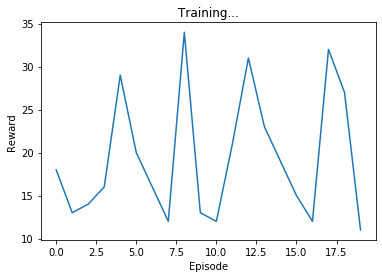

Failed to reach OpenAIGymStandard
Best 100 episode average:  -inf  reached at episode  inf . Model saved in folder best.
Complete


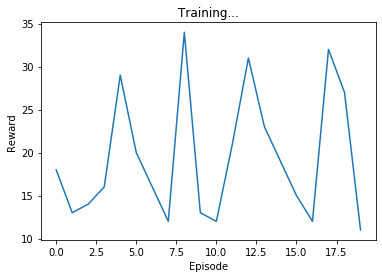

In [13]:
torch.manual_seed(467)
random.seed(208)
gym_seed = 216

optimizer = optim.Adam(policy_net.parameters(), lr=LEARNING_RATE)
start = time.time()
train_agent.train_agent(env,policy_net,target_net,BATCH_SIZE,DISCOUNT_FACTOR,EPSILON_START,
            EPSILON_END,EPSILON_DECAY,TARGET_UPDATE_FREQUENCY,optimizer,LEARNING_RATE,
            REPLAY_MEMORY_SIZE,device,GYM_TARGET_AVG,GYM_TARGET_DURATION,num_episodes=NUM_EPISODES,
            max_steps=MAX_STEPS,render=RENDER,double_q_learning=DOUBLE_Q,gradient_clipping=GRADIENT_CLIPPING,
            initial_replay_size=INITIAL_REPLAY_SIZE,gym_seed=gym_seed)

chris_policy = policy_net
chris_target = target_net

In [14]:
time.time()-start

49.31044578552246

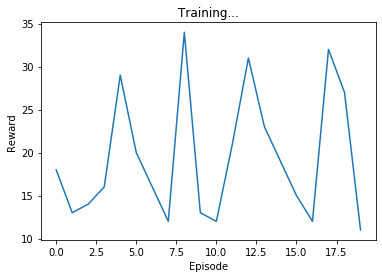

Failed to reach OpenAIGymStandard
Best 100 episode average:  -inf  reached at episode  inf . Model saved in folder best.
Complete


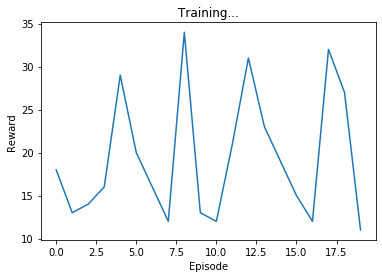

In [15]:
policy_net = my_net
target_net = my_target_net

torch.manual_seed(467)
random.seed(208)
gym_seed = 216

optimizer = optim.Adam(policy_net.parameters(), lr=LEARNING_RATE)
start = time.time()
train_agent.train_agent(env,policy_net,target_net,BATCH_SIZE,DISCOUNT_FACTOR,EPSILON_START,
            EPSILON_END,EPSILON_DECAY,TARGET_UPDATE_FREQUENCY,optimizer,LEARNING_RATE,
            REPLAY_MEMORY_SIZE,device,GYM_TARGET_AVG,GYM_TARGET_DURATION,num_episodes=NUM_EPISODES,
            max_steps=MAX_STEPS,render=RENDER,double_q_learning=DOUBLE_Q,gradient_clipping=GRADIENT_CLIPPING,
            initial_replay_size=INITIAL_REPLAY_SIZE,gym_seed=gym_seed)

In [16]:
time.time()-start

40.78834009170532

In [17]:
testinp = torch.tensor([[.1,.1,.1,1]], dtype=torch.float, device=device)
print(chris_policy.forward(testinp)[0,0].item())
print(policy_net.forward(testinp)[0,0].item())


3.1065752506256104
3.1065752506256104


In [18]:
print(list(chris_policy.parameters())[1].grad[1,0].item())

print(list(policy_net.parameters())[1].grad[1,0].item())


1.088164481188869e-06
1.088164481188869e-06


In [19]:
print(list(chris_policy.parameters())[0].grad[1,1].item())

print(list(policy_net.parameters())[0].grad[1,1].item())

-0.013502679765224457
-0.013502679765224457


In [20]:

chris_policy.parameters()[0][0,0].item()

-0.030953243374824524

In [21]:
list(policy_net.parameters())[0][0,0].item()

-0.030953243374824524